In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import torch
import torch.nn as nn
import torch.optim as optim

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
torch.cuda.empty_cache() # Run if the kernel starts dying, notebook doesn't clear automatically
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Defined for flattening input image inside our model
class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.shape[0], -1)

In [5]:
def bound_propagation(model, initial_bound):
    l, u = initial_bound
    bounds = []
    
    for layer in model:
        if isinstance(layer, Flatten):
            l_ = Flatten()(l)
            u_ = Flatten()(u)
        elif isinstance(layer, nn.Linear):
            l_ = (layer.weight.clamp(min=0) @ l.t() + layer.weight.clamp(max=0) @ u.t() 
                  + layer.bias[:,None]).t()
            u_ = (layer.weight.clamp(min=0) @ u.t() + layer.weight.clamp(max=0) @ l.t() 
                  + layer.bias[:,None]).t()
        elif isinstance(layer, nn.Conv2d):
            l_ = (nn.functional.conv2d(l, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(u, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  layer.bias[None,:,None,None])
            
            u_ = (nn.functional.conv2d(u, layer.weight.clamp(min=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) +
                  nn.functional.conv2d(l, layer.weight.clamp(max=0), bias=None, 
                                       stride=layer.stride, padding=layer.padding,
                                       dilation=layer.dilation, groups=layer.groups) + 
                  layer.bias[None,:,None,None])
            
        elif isinstance(layer, nn.ReLU):
            l_ = l.clamp(min=0)
            u_ = u.clamp(min=0)
            
        bounds.append((l_, u_))
        l,u = l_, u_
    return bounds

In [6]:
import cvxpy as cp

def form_milp(model, c, initial_bounds, bounds):
    linear_layers = [(layer, bound) for layer, bound in zip(model,bounds) if isinstance(layer, nn.Linear)]
    d = len(linear_layers)-1
    
    # create cvxpy variables
    z = ([cp.Variable(layer.in_features) for layer, _ in linear_layers] + 
         [cp.Variable(linear_layers[-1][0].out_features)])
    v = [cp.Variable(layer.out_features, boolean=True) for layer, _ in linear_layers[:-1]]
    
    # extract relevant matrices
    W = [layer.weight.detach().cpu().numpy() for layer,_ in linear_layers]
    b = [layer.bias.detach().cpu().numpy() for layer,_ in linear_layers]
    l = [l[0].detach().cpu().numpy() for _, (l,_) in linear_layers]
    u = [u[0].detach().cpu().numpy() for _, (_,u) in linear_layers]
    l0 = initial_bound[0][0].view(-1).detach().cpu().numpy()
    u0 = initial_bound[1][0].view(-1).detach().cpu().numpy()
    
    # add ReLU constraints
    constraints = []
    for i in range(len(linear_layers)-1):
        constraints += [z[i+1] >= W[i] @ z[i] + b[i], 
                        z[i+1] >= 0,
                        cp.multiply(v[i], u[i]) >= z[i+1],
                        W[i] @ z[i] + b[i] >= z[i+1] + cp.multiply((1-v[i]), l[i])]
    
    # final linear constraint
    constraints += [z[d+1] == W[d] @ z[d] + b[d]]
    
    # initial bound constraints
    constraints += [z[0] >= l0, z[0] <= u0]
    
    return cp.Problem(cp.Minimize(c @ z[d+1]), constraints), (z, v)

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST("../data", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.MNIST("../data", train=False, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(mnist_train, batch_size = 100, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size = 100, shuffle=False)

In [8]:
for X,y in test_loader:
    X,y = X.to(device), y.to(device)
    break

In [19]:
class Model(nn.Module):
    def __init__(self, module_list):
        super(Model, self).__init__()
        self.model = nn.ModuleList(module_list)

    def __iter__(self):
        ''' Returns the Iterator object '''
        return iter(self.model)

    def __len__(self):
        return len(self.model)

    def __getitem__(self, index):
        return self.model[index]

    def __setitem__(self, idx, value):
        self.model[idx] = value

    def register_backward_hooks(self):
        for module_pt in self.model:
            if hasattr(module_pt,'register_masking_hooks'):
                module_pt.register_masking_hooks()
    
    def unregister_backward_hooks(self):
        for module_pt in self.model:
            if hasattr(module_pt,'unregister_masking_hooks'):
                module_pt.unregister_masking_hooks()    

    def forward(self, x):
        for module_pt in self.model:
            x = module_pt(x)
        return x
    
    
    
class FullyConnectedBaselineModel(Model):
    def __init__(self, name='FCBaseline', input_size=784, n_output_classes=10, n_channels=-1):
        self.name = name
        module_list = [
            Flatten(), 
            nn.Linear(input_size, 50), 
            nn.ReLU(True),
            nn.Linear(50, 20), 
            nn.ReLU(True),
            nn.Linear(20, n_output_classes)
        ]

        super(FullyConnectedBaselineModel, self).__init__(module_list)

In [30]:
PATH = '/Users/patrickherbert/Documents/Classes/Spring 2020/DL in DO/Project/mip-for-ann-master/experiments/FCBaseline/lr_2/epoch_20/dataset_0/optimizer_2/exp_4/FCBaseline.pt'
model_info = torch.load(PATH, map_location=torch.device('cpu'))
model_state_dict = model_info.get("model_state_dict")
model = FullyConnectedBaselineModel()
model.load_state_dict(model_state_dict)
model

FullyConnectedBaselineModel(
  (model): ModuleList(
    (0): Flatten()
    (1): Linear(in_features=784, out_features=50, bias=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=50, out_features=20, bias=True)
    (4): ReLU(inplace=True)
    (5): Linear(in_features=20, out_features=10, bias=True)
  )
)

In [31]:
# Model definition
model_dnn_2 = nn.Sequential(Flatten(), nn.Linear(784,200), nn.ReLU(), 
                            nn.Linear(200,10)).to(device)

# Loading in trained parameters
model_dnn_2.load_state_dict(torch.load("model_dnn_2.pt", map_location=torch.device('cpu')))

<All keys matched successfully>

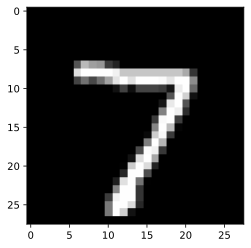

In [32]:
# Change X[i][0] to see different images
matplotlib.pyplot.imshow(X[0][0].cpu().numpy(), cmap='gray');

Change values in this portion to mess with individual images and run them on the trained model. The index of the maximum value in the resulting array corresponds to the predicted image label

In [33]:
test_data = X[0:1][0]  # This is the first image, X[1:2][0] would be the second image and so on. 
model(test_data)

tensor([[ -4.6062,  -1.6525,  -1.0411,   7.0792,  -6.5076,   1.3499, -13.7148,
          14.7904,   1.0817,   1.0619]], grad_fn=<AddmmBackward>)

In this section you can play around with different variable values for the MIP program. 

In [34]:
epsilon = 0.1 # Change how much the pixels can change in order to create an adversarial example
im_num = 0    # Change which test image we're accessing
new_label = 2 # Set the label for which we want to find an adversarial example for im_num, 0 for 0 and so on up to 9

And then set it up the problem to feed into Gurobi

In [35]:
initial_bound = ((X[im_num:im_num + 1] - epsilon).clamp(min=0), (X[im_num:im_num + 1] + epsilon).clamp(max=1))
bounds = bound_propagation(model, initial_bound)
c = np.zeros(10)        # Creating the objective function for the MIP
c[y[im_num].item()] = 1 # y is the correct label for the image selected, setting it to 1 minimzes it in the O.F.
c[new_label] = -1       # Maximize the incorrect label we set above in the O.F.

prob, (z, v) = form_milp(model, c, initial_bound, bounds)

Solve MIP to find an adversarial example, if the O.F.V is negative then we have successfully found one. 

In [36]:
prob.solve(solver=cp.GUROBI, verbose=True)

Parameter OutputFlag unchanged
   Value: 1  Min: 0  Max: 1  Default: 1
Changed value of parameter QCPDual to 1
   Prev: 0  Min: 0  Max: 1  Default: 0
Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (mac64)
Optimize a model with 1858 rows, 934 columns and 82598 nonzeros
Model fingerprint: 0x301c9622
Variable types: 864 continuous, 70 integer (70 binary)
Coefficient statistics:
  Matrix range     [7e-06, 5e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e-03, 4e+01]
Presolve removed 1653 rows and 12 columns
Presolve time: 0.09s
Presolved: 205 rows, 922 columns, 76782 nonzeros
Variable types: 855 continuous, 67 integer (67 binary)

Root relaxation: objective -7.856908e+01, 123 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  -78.56908    0   35          -  -78.56908      -     -    0s
     0     0  -72.88

-13.918895685086216

Now we can plot the perturbed image that we found to see what it looks like.


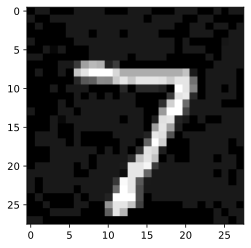

In [37]:
plt.imshow(z[0].value.reshape(28,28), cmap="gray");

Finally, we run the perturbed image through the trained model as a sanity check to validate the results we found. 

In [38]:
perturbed_data = torch.tensor(z[0].value).float()
perturbed_data = perturbed_data.view(1,28,-1)
model(perturbed_data)

tensor([[ 1.3746,  1.0886,  8.9649,  0.7422, -5.6423, -4.7452, -6.1192, -4.9540,
          6.8407, -1.0122]], grad_fn=<AddmmBackward>)